# Example: Macro Parameter Optimization

Use surrogate modeling toolbox to optimize for a decent set of parameters.

Run multiple tests (i.e., lots of initial conditions) to make sure the parameters are actually good

<div class="alert alert-info">

**TODO**:
- Decide how much of the following to expose directly to user:
  - get_samples, CostFunction, optimize, transform ... some of these should probably go to utils
- This is somewhat boring, we're just making dicts... is there a way to make it more ... interactive? more plots?
- docstrings

</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
plt.style.use("./xesn.mplstyle")

## Create training, macro training, and testing data

In [3]:
from lorenz import Lorenz96

In [4]:
model = Lorenz96(N=12)

In [5]:
n_spinup = 2_000
n_train = 40_000
n_macro_training = 10_000
n_transient = 5_000
n_test = 10_000

n_total = n_spinup+n_train+n_macro_training+n_transient + n_test
rs = np.random.RandomState(1)
trajectory = model.generate(n_steps=n_total, x0=rs.normal(size=(model.N,)))

In [6]:
from xesn import psd

In [7]:
trainer = trajectory.isel(time=slice(n_spinup, n_spinup+n_train+1))
macro_trainer = trajectory.isel(time=slice(n_spinup+n_train, n_spinup+n_train+n_macro_training+1))
tester = trajectory.isel(time=slice(-n_test-1, None))

In [8]:
psi = psd(trainer)

### Normalization

In [9]:
bias = trainer.mean()
scale = trainer.std()

normalize = lambda xda : (xda - bias) / scale

trainer = normalize(trainer)
macro_trainer = normalize(macro_trainer)
tester = normalize(tester)

## Get Sample Trajectories for optimization

- We need several trajectories to optimize over, we'll use 10 (5-10 worked well for Platt et al)
- This pulls enough information for the ESN spinup period as well as the prediction phase
- Grab these at random without replacement from a separate dataset from the test dataset.
  Note that we could grab from the training, or from a separate section of data as we are here ... this is up to the user...
  Just don't grab from the test dataset!
- We will set the options for [get_samples](generated/xesn.utils.get_samples.rst) in a dictionary because we will use them
  later

In [15]:
from xesn.utils import get_samples

In [16]:
forecast_kwargs = {
    "n_samples": 5, # number of samples to grab
    "n_steps": 500, # how long are the sample trajectories to optimize over
    "n_spinup": 100, # how long is the pre-prediction spinup period
    "random_seed": 10,
}

In [17]:
macro_trainers, indices = get_samples(
    xda=macro_trainer,
    **forecast_kwargs
)    

<div class="alert alert-info">

**Note**: [get_samples](generated/xesn.utils.get_samples.rst) expects the input dataset to have a labelled dimension
``"time"``, which it uses to pull sample trajectories from. See the plot below, which shows the first dimension
of the sample Lorenz96 trajectories that we grabbed from the `macro_trainer` dataset, which has time spanning
from 420-520 MTU.

</div>

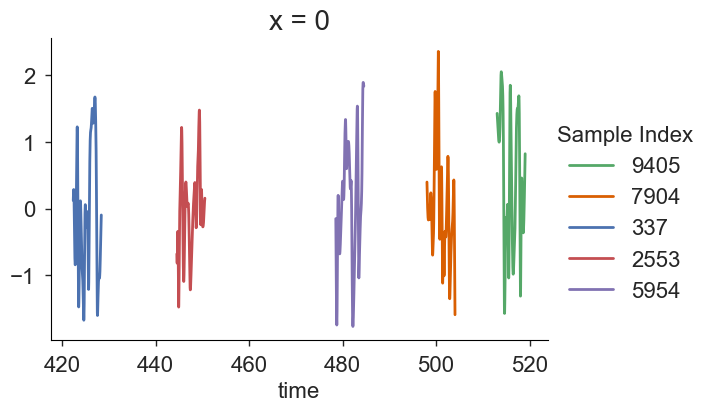

In [102]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
for mt in macro_trainers:
    mt.isel(x=0).plot(label=mt.sample_index, ax=ax)
ax.legend(title="Sample Index", loc=(1., .1), )

## Cost and Optimization Configuration

Here we have to setup a nested dictionary that will specify the many subcomponents that are important for the optimization problem.
The subcomponents are:
1. The `macro_training` configuration, specifying how to do the optimization. We'll break this down piece by piece.
2. The generic ESN configuration. Basically, everything that needs to be fixed other than the parameters we want to optimize.
3. The `training` options, consisting of any of the optional keyword arguments that get passed to
   [ESN.train()](generated/xesn.ESN.train.rst) or [LazyESN.train()](generated/xesn.LazyESN.train.rst).

### Macro Training Configuration

**Parameters**

First, we set the parameters to be optimized, along with bounds for the optimization.
In this example, we'll set the five uncertain scalar parameters noted in
[the methods](methods.rst#macro-scale-parameters).
- Input factor: $\sigma \in [0, 2]$
- Adjacency factor: $\rho \in [0, 2]$
- Bias factor: $\sigma_b \in [0, 2]$
- Leak rate: $\alpha \in [0, 1]$
- Tikhonov parameter: $\beta \in [10^{-12}, 1]$

In [19]:
optim_parameters = {
    "input_factor": [0., 2.],
    "adjacency_factor": [0., 2.],
    "bias_factor": [0., 2.],
    "leak_rate": [0., 1.],
    "tikhonov_parameter": [1.e-12, 1.],
}

**Transformations**

Additionally, we can set transformations so that the optimization is performed in a transformed space.
Currently, there are only two available options: ``"log10"`` and ``"log"``.
This allows us to explore a space that spans several orders of magnitude, which is particularly nice for the regularization parameter.

In [20]:
optim_transformations = {
    "tikhonov_parameter": "log10",
}

**Cost Terms**

Here we formulate the cost function. Currently, the cost function is made up of two possible
terms:
$$
\mathcal{J}_\text{macro}(\theta) =
\dfrac{1}{N_\text{macro}}\sum_{j=1}^{N_\text{macro}}
\left\{
    \gamma_1\text{NRMSE}(j) + \gamma_2 \text{PSD\_NRMSE}(j)
\right\}
$$
where
- $N_\text{macro}$ = `forecast_kwargs["n_samples"]` is the number of sample forecasts
- $\gamma_1$ and $\gamma_2$ determine the overall weighting for the $NRMSE$ and
  $PSD\_NRMSE$ terms, respectively
- $\text{NRMSE}(j)$ is the normalized root-mean-square error of sample forecast $j$, which is
  defined as follows

  $$
  \text{NRMSE}(j) = \sqrt{
      \dfrac{1}{N_v N_\text{steps}}
      \sum_{n=1}^{N_\text{steps}}
      \sum_{i=1}^{N_v}
      \left(
          \dfrac{\hat{v}_j(i, n) - v_j(i, n)}{SD_j}
      \right)^2 } \, ,
  $$
  where
  - $i$ is the index for each non-time index ($N_v = 12$ in our example)
  - $n$ is the temporal index, and $N_\text{steps}$ = `forecast_kwargs["n_steps"]` is the
    length of each sample forecast in terms of the number of time steps
  - $j$ is the index for each sample forecast
  - $SD_j$ is the standard deviation of the sample forecast, taken over space and time
   $$
   SD = \dfrac{1}{(N_{\text{steps}}-1)(N_v-1)}
    \sqrt{
        \sum_{i=1}^{N_v}\sum_{n=1}^{N_{\text{steps}}}\left(v_j(i, n) - \mu_j\right)^2
        }
   $$
   where $\mu_j$ is the sample average taken over space and time
   $\mu_j =
   \dfrac{1}{N_v N_\text{steps}}
   \sum_{n=1}^{N_\text{steps}}
   \sum_{i=1}^{N_v}
   v_j(i,n)$
- $\text{PSD\_NRMSE}(j)$ is the NRMSE of the Power Spectral Density (PSD) for each sample.
  The terms is as follows
  $$
  \text{PSD\_NRMSE}(j) =
      \dfrac{1}{N_K N_\text{steps}}
      \sum_{n=1}^{N_\text{steps}}
      \sum_{i=1}^{N_K}
      \left(
          \dfrac{\hat{\psi}_j(k, n) - \psi_j(k, n)}{SD_j(k)}
      \right)^2  \, ,
  $$
  where
  - indices $j$, $n$ are the same as for NRMSE
  - $k$ is the index for each spectral mode of the PSD
  - $\psi_j(k,n)$ is the $k^{th}$ mode's amplitude, for sample $j$ at time step $n$
  - $SD_j(k)$ is defined similarly as above, but in spectral space, and note that each
    mode is normalized separately as different modes can vary by vastly different orders of
    magnitude

<div class="alert alert-info">
    
Note

The motivation for prioritizing the PSD in the cost function stems from
Platt et al., who showed that by prioritizing invariants like the Lyapunov Exponent, or possibly the PSD,
 fewer sample trajectories are needed during the optimization process in order to get a good parameter set,
 and from Smith et al., who showed that prioritizing the Kinetic Energy spectrum of turbulent geofluids encourages 
 ESNs that better represent small scale processes in the flow.

This is new research!
</div>

In this example, we employ a simple mixture of the two cost terms, setting
$\gamma_1 = \gamma_2 = 1$.
Note that getting the right balance of these two terms is likely to be application dependent.

In [21]:
cost_terms = {"nrmse": 1., "psd_nrmse": 1.}

### ESN Configuration and Training Options

As noted above, here we set everything that we want to stay fixed in the ESN during optimization.
Note that the values for the optimization parameters that we choose here have *no influence* on the optimization whatsoever.
The optimization is initialized using a sophisticated random sampling strategy, see [here](https://smt.readthedocs.io/en/latest/_src_docs/sampling_methods.html) for options.

In [22]:
esn_kwargs = {
    "n_input": model.N,
    "n_output": model.N,
    "n_reservoir": 1000,
    "leak_rate": 0.5, # value doesn't matter
    "tikhonov_parameter": 1e-6, # value doesn't matter
    "input_kwargs":{
        "factor": 0.5, # value doesn't matter
        "normalization": "svd",
        "distribution": "uniform",
        "random_seed": 0,
    },
    "adjacency_kwargs":{
        "factor": 0.5, # value doesn't matter
        "normalization": "svd",
        "distribution": "uniform",
        "is_sparse": True,
        "connectedness": 5,
        "random_seed": 1,
    },
    "bias_kwargs":{
        "factor": 0.5, # value doesn't matter
        "distribution": "uniform",
        "random_seed": 2,
    },
}

In [23]:
training_kwargs = {
    "n_spinup": 0,
    "batch_size": 20_000,
}

### The `config` dictionary 

At last, we specify the configuration by pulling all of the subcomponents together.

Note that the `macro_training` section also needs a `forecast` subsection, which we specified earlier to generate the samples.
The `forecast_kwargs` used to generate samples and during optimization must be consistent with one another.

In [24]:
config = {
    "macro_training": {
        "parameters": optim_parameters,
        "transformations": optim_transformations,
        "forecast": forecast_kwargs,
        "cost_terms": cost_terms,
    },
    "esn": esn_kwargs, # note this section would be "lazyesn" if that model was used
    "training": training_kwargs
}

## Set up cost function

In [25]:
from xesn.cost import CostFunction
from xesn import ESN
from xesn.optim import transform

In [26]:
cf = CostFunction(
    ESN=ESN, # this could also be xesn.LazyESN
    train_data=trainer,
    macro_data=macro_trainers,
    config=config,
)

Now lets evaluate the cost function on a guessed set of parameters.

In [27]:
p_guess = {
    "input_factor": 0.5,
    "adjacency_factor": 0.9,
    "bias_factor": 0.,
    "leak_rate": 0.5,
    "tikhonov_parameter": 1.e-6,
}

In [28]:
params_transformed = transform(p_guess, config["macro_training"]["transformations"])

In [29]:
params_transformed

{'input_factor': 0.5,
 'adjacency_factor': 0.9,
 'bias_factor': 0.0,
 'leak_rate': 0.5,
 'tikhonov_parameter': -6.0}

In [30]:
cf(list(params_transformed.values()))

array([[7843.79531606]])

This is the evaluated cost of our random configuration.
Note that under the hood, the [CostFunction](generated/xesn.CostFunction.rst):
- creates an ESN
- assigns the parameter values for this sample
- builds and trains the readout weights
- makes `forecast_kwargs["n_samples"]` sample forecasts
- computes the cost compared to the provided `macro_data` datasets

### Visualizing the Cost

Here we go through the steps outlined above to give a visual impression of how our model performed on a single sample, in order to see what the NRMSE and PSD_NRMSE might look like.

In [31]:
from xesn.cost import _update_esn_kwargs

In [32]:
guess_kwargs = _update_esn_kwargs(p_guess, esn_kwargs)

In [33]:
esn_guess = ESN(**guess_kwargs)
esn_guess.build()
esn_guess.train(trainer, **config["training"])

In [34]:
gds = esn_guess.test(
    macro_trainers[0],
    n_steps=config["macro_training"]["forecast"]["n_steps"],
    n_spinup=config["macro_training"]["forecast"]["n_spinup"],
)

First, visually compare the prediction and the truth from our `macro_training` set.

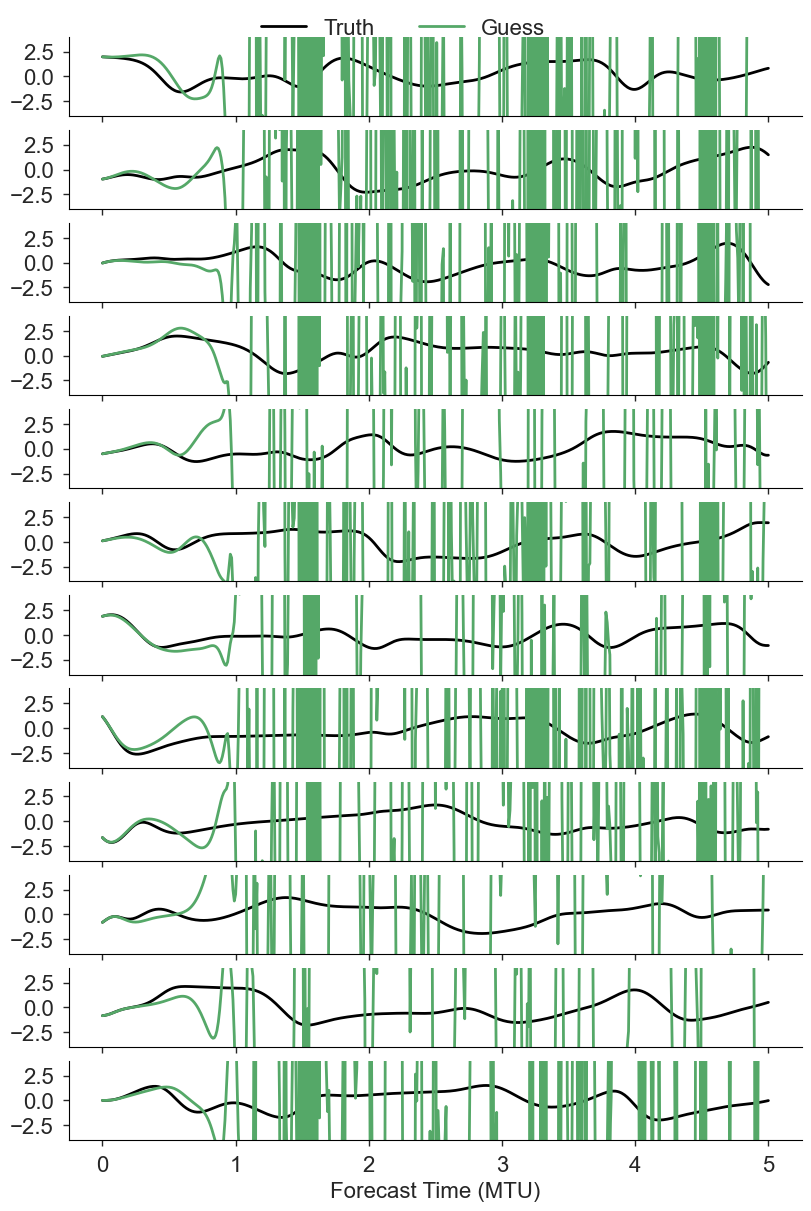

In [35]:
nrows = len(gds.x)
fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)

for i, ax in enumerate(axs):
    gds["truth"].isel(x=i).plot(ax=ax, color="k", label="Truth")
    gds["prediction"].isel(x=i).plot(ax=ax, label="Guess")
    ax.set(ylabel="", xlabel="", title="")
ax.set(xlabel="Forecast Time (MTU)", ylim=(-4,4))
axs[0].legend(loc=(.25,.87),ncol=3)

Now compute the NRMSE as a function of forecast time, and the PSD as a function of wavenumber.

In [37]:
from xesn import psd

In [38]:
se = (gds["prediction"] - gds["truth"])**2
nse = se / gds.truth.var("ftime")
nrmse = np.sqrt(nse).mean("x")

gpsd = {
    "Truth": psd(gds["truth"]),
    "Guess": psd(gds["prediction"]),
}

In [39]:
import seaborn as sns

[Text(0, 0.5, 'PSD'), Text(0.5, 0, 'Wavenumber'), None]

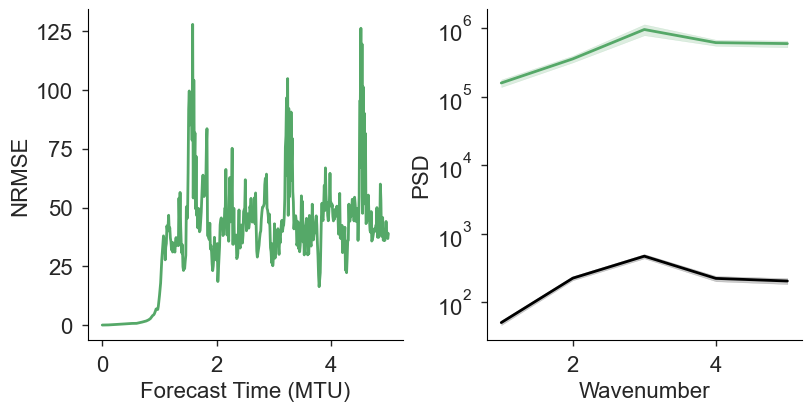

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

nrmse.plot(ax=axs[0])

for key, color in zip(["Truth", "Guess"], ["k", None]):
    sns.lineplot(
        gpsd[key].to_dataset(name=key).to_dataframe().reset_index(),
        x="k1d",
        y=key,
        ax=axs[1],
        color=color,
    )
axs[0].set(ylabel="NRMSE", xlabel="Forecast Time (MTU)")
axs[1].set(ylabel="PSD", xlabel="Wavenumber", yscale="log")

It doesn't look like a very good guess.

## Macro-Scale Parameter Optimization

At last, we provide our parameter cost function to the [optimize](generated/xesn.optimize.rst) function, 
which basically passes the cost function to the surrogate modeling toolbox's
[Efficient Global Optimization](https://smt.readthedocs.io/en/latest/_src_docs/applications/ego.html)
class, which performs Bayesian Optimization.
All keyword arguments to [optimize](generated/xesn.optimize.rst)
are passed to `smt.applications.EGO`, see a list of all possible options
[here](https://smt.readthedocs.io/en/latest/_src_docs/applications/ego.html#options).

In [41]:
from xesn.optim import optimize

In [42]:
%%time
p_opt = optimize(
    cost_function=cf,
    # all other kwargs get passed to smt.EGO
    n_iter=5,
    n_doe=10,
    n_parallel=4,
    random_state=5,
)

/Users/tsmith/work/xesn/xesn/esn.py:499: LinAlgWarning: Ill-conditioned matrix (rcond=5.24221e-22): result may not be accurate.
  Wout = solve(rbar.T, ybar.T, **kw)
/Users/tsmith/work/xesn/xesn/esn.py:499: LinAlgWarning: Ill-conditioned matrix (rcond=5.82135e-17): result may not be accurate.
  Wout = solve(rbar.T, ybar.T, **kw)
/Users/tsmith/work/xesn/xesn/esn.py:499: LinAlgWarning: Ill-conditioned matrix (rcond=3.18865e-17): result may not be accurate.
  Wout = solve(rbar.T, ybar.T, **kw)



 --- Optimization Results ---

Optimal inputs:
	input_factor                : 0.416148253752975
	adjacency_factor            : 0.17414646123547528
	bias_factor                 : 1.7740966174002968
	leak_rate                   : 0.4253588205773788
	tikhonov_parameter          : 1.5598280907338211e-07

Approximate cost minimum:
	[1.56521136]

CPU times: user 29min 23s, sys: 46.1 s, total: 30min 9s
Wall time: 3min 3s


## Evaluate the Optimized ESN

Here we set up a function to test the optimized ESN and guessed ESN setups, and compute some evaluation metrics.

In [86]:
def test_esn(params, esn_kw, train_data, test_data, cfg, n_test_samples=20):

    kwargs = _update_esn_kwargs(params, esn_kw)
    esn = ESN(**kwargs)
    esn.build()
    esn.train(trainer, **cfg["training"])

    test_kw = cfg["macro_training"]["forecast"].copy()
    test_kw["n_samples"] = 20

    norm_inv = lambda x : x*scale+bias

    dslist = []
    for i, this_test in enumerate(test_data):
        result = esn.test(this_test, n_steps=test_kw["n_steps"], n_spinup=test_kw["n_spinup"])
        with xr.set_options(keep_attrs=True):
            for key in ["truth", "prediction"]:
                result[key] = norm_inv(result[key])
                
        result["ftime"] = result["ftime"].astype(np.float32)
        result["psd_truth"] = psd(result["truth"])
        result["psd_prediction"] = psd(result["prediction"])
        result = result.expand_dims({"sample": [i]})
        dslist.append(result)

    xds = xr.concat(dslist, dim="sample")
    
    se = (xds["prediction"] - xds["truth"])**2
    nse = se / xds.truth.var("ftime")
    xds["nrmse"] = np.sqrt(nse).mean("x")
    return xds

In [87]:
%%time
gds = test_esn(p_guess, esn_kwargs, trainer, macro_trainers, config)
ods = test_esn(p_opt, esn_kwargs, trainer, macro_trainers, config) 

CPU times: user 2min 1s, sys: 6.64 s, total: 2min 8s
Wall time: 11.9 s


### First, visually compare the predictions with the truth

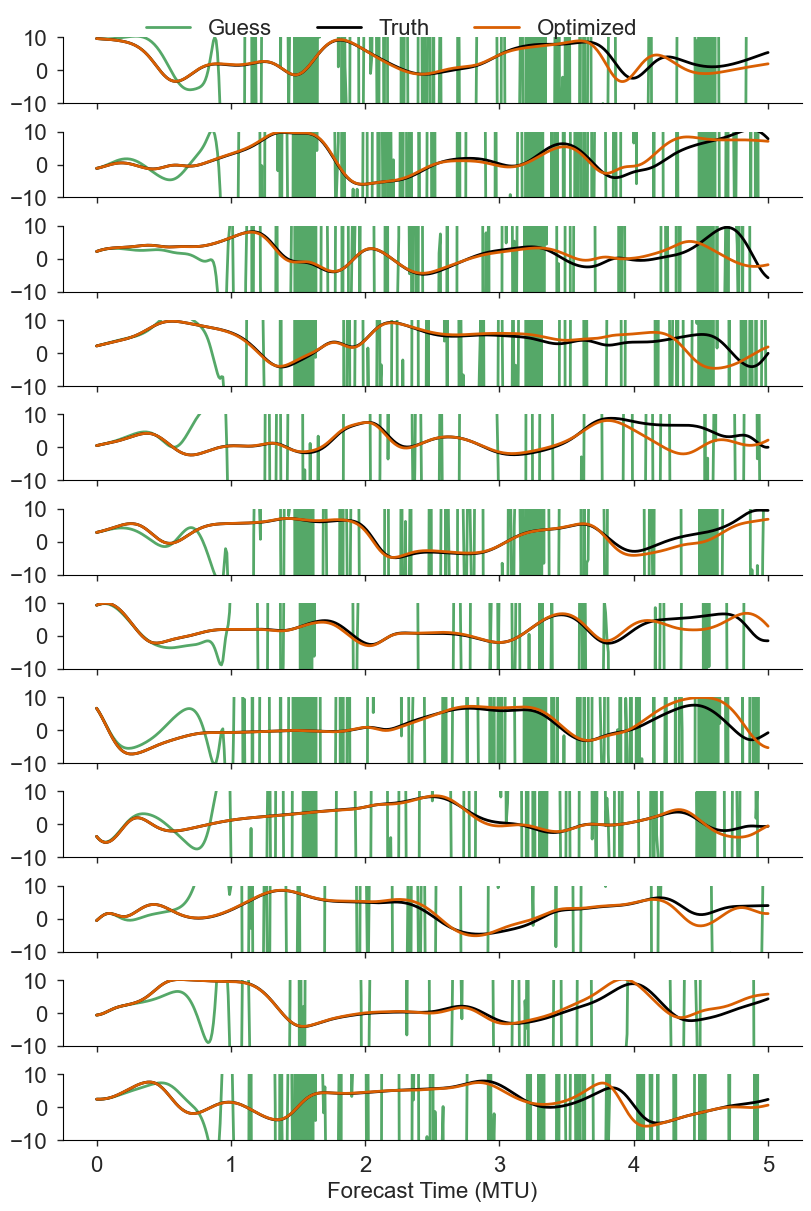

In [103]:
nrows = len(ods.x) 
fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)

for i, ax in enumerate(axs):
    gds["prediction"].isel(x=i, sample=0).plot(ax=ax, label="Guess")
    ods["truth"].isel(x=i, sample=0).plot(ax=ax, color="k", label="Truth")
    ods["prediction"].isel(x=i, sample=0).plot(ax=ax, label="Optimized")
    ax.set(ylabel="", xlabel="", title="")
ax.set(xlabel="Forecast Time (MTU)", ylim=(-10,10))
axs[0].legend(loc=(.1,.85),ncol=3)

### Compare NRMSE and PSD over many test samples 

In [54]:
import seaborn as sns

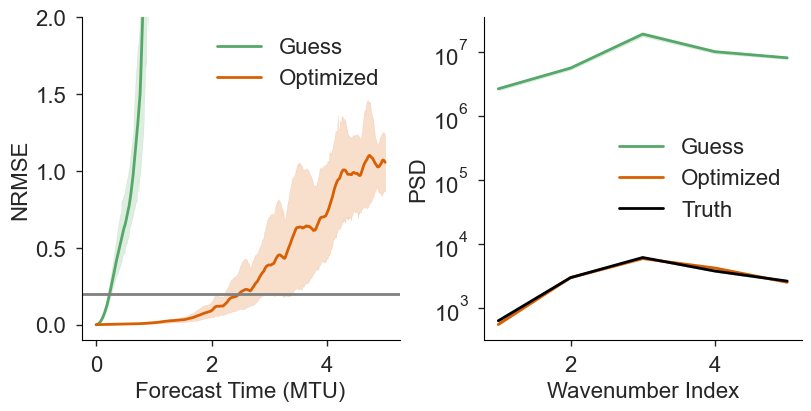

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

for xds, label in zip([gds, ods], ["Guess", "Optimized"]):
    sns.lineplot(
        data=xds["nrmse"].to_dataset(name="NRMSE").to_dataframe().reset_index(),
        x="ftime",
        y="NRMSE",
        ax=axs[0],
        label=label,
    )
for xda, label in zip(
    [gds["psd_prediction"],
     ods["psd_prediction"],
     ods["psd_truth"]
    ],
    ["Guess", "Optimized", "Truth"]):
    
    sns.lineplot(
        data=xda.to_dataset(name=label).to_dataframe().reset_index(),
        x="k1d",
        y=label,
        ax=axs[1],
        color="k" if label == "Truth" else None,
        label=label,
    )
axs[0].set(ylim=(-.1, 2), xlabel="Forecast Time (MTU)")
axs[0].axhline(y=.2, color="gray")
axs[1].set(yscale="log", xlabel="Wavenumber Index", ylabel="PSD")
[ax.legend() for ax in axs];

With the optimized architecture, we hit a NRMSE at around 2.5 MTU, and the PSD looks much closer to the truth